In [5]:
#!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/kaibrach/machine-learning/master/bayesian-linear-regression/bayesian_linear_regression_util.py

# Linear Models for Regression


This notebook is an introduction to Bayesian regression with linear basis function models as described in [1](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).
The references [2](https://doc.lagout.org/science/Artificial%20Intelligence/Machine%20learning/Machine%20Learning_%20A%20Probabilistic%20Perspective%20%5BMurphy%202012-08-24%5D.pdf) and [3](http://www.gaussianprocess.org/gpml/) are also taken into account, but the implementation, as well as the variable names are implemented as described in [1].

It covers the idea of using [probability distribution](https://en.wikipedia.org/wiki/Probability_distribution) over parameters (weight-space view), in detail the [Normal- or Gaussian distribution](https://en.wikipedia.org/wiki/Normal_distribution) in combination with [Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem).
 
$\textbf{Info:}$ Probability distribution over functions (function-space view) will be handled in the notebook `gaussian_processes`
 
To understand the mathematics and to implement the formulas close to the book [1], the Bayesian linear regression is implemented from scratch without any additional libraries such as [PyMC3](https://docs.pymc.io/) or [scikit-learn](https://scikit-learn.org/stable/) , only $\textit{numpy}$ is used for doing the maths and $\textit{matplotlib}$ for plotting the results. 

Further, in this notebook, the mathematical derivations provided in [Introduction to Bayesian Linar Regression](https://estadistika.github.io/data/analyses/wrangling/julia/programming/packages/2018/10/14/Introduction-to-Bayesian-Linear-Regression.html) is used.

$\textbf{Optional/Additional}$

The library *scikit-learn* and *PyMC3*  are used to demonstrate how to use this libs and to show that the equivalent values can be obtained for Bayesian regression in a view lines of code.



## Linear Basis Function Models

The simplest linear model for regression is one that involves a linear combination of
the input variables

$$
y(\mathbf{x}, \mathbf{w}) = w_0 + w_1x_1 + \ldots w_Dx_D
$$

where $\mathbf{x} = (x_1,\ldots,x_D)^T$.  

Because this is a linar function of the parameters (weights) $w_0,\ldots,w_D$ as well as of the input variables $\mathbf{x} = (x_1,\ldots,x_D)^T$ this model has significant limitations. 

The idea is to extend this model by considering linear combinations of fixed non-linear functions of the
input variables. Using non-linear basis functions of input variables, linear models are able model arbitrary non-linearities from input variables to targets.

For example polynomial regression, or gaussian is such a model that can be defined, but there are many other possible choices for basic functions.

A linear regression model $y(\mathbf{x}, \mathbf{w})$ can therefore be defined more generally as

$$
y(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=1}^{M-1}{w_j \phi_j(\mathbf{x})} = \sum_{j=0}^{M-1}{w_j \phi_j(\mathbf{x})} = \mathbf{w}^T \boldsymbol\phi(\mathbf{x}) \tag{1}
$$

where $\phi_j$ are basis functions and $M$ is the total number of parameters $w_j$ including the bias term $w_0$.
Here, we use the convention for the `dummy basis function`$\phi_0(\mathbf{x}) = 1$.

## Maximum likelihood and least squares

As mentioned above simplest form of linear regression models are also linear functions of their input variables i.e. the set of basis functions in this case is the identity $\boldsymbol\phi(\mathbf{x}) = \mathbf{x}$.
The target variable $t$ of an observation $\mathbf{x}$ is given by a deterministic function $y(\mathbf{x}, \mathbf{w})$ plus additive Gaussian noise $\epsilon$.

$$
t = y(\mathbf{x}, \mathbf{w}) + \epsilon \tag{2}
$$

where $\epsilon$ is a zero mean random variable  $ \epsilon \sim \mathcal{N}(0, \sigma^2)$ with precision (inverse variance) $\beta = {1 \over \sigma^2}$

The corresponding probabilistic model i.e. the conditional distribution of $t$ given $\mathbf{x}$ can therefore be written as (insert in normal distribution)

 $$
 p(t \lvert \mathbf{x}, \mathbf{w}, \beta) =
 \mathcal{N}(t \lvert y(\mathbf{x}, \mathbf{w}), \beta^{-1}) =
 \sqrt{\beta \over {2 \pi}} \exp\left(-{\beta \over 2} (t - y(\mathbf{x}, \mathbf{w}))^2 \right) \tag{3}
 $$

 where the mean of this distribution is the regression function $y(\mathbf{x}, \mathbf{w})$.

### Likelihood function
To be able to fit the model and for inference of the model parameters $w$ and $\beta$ we consider a data set (training data) of $N$ independent and identically distributed (i.i.d.) observations $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and their corresponding targets $t_1,\ldots,t_N$.
After combining column vectors $\mathbf{x}_i$ into matrix $\mathbf{X}$, where $\mathbf{X}_{i,N} = \mathbf{x}_i^T$, and scalar targets
$t_i$ into column vector $\mathbf{t}$ the joint conditional probability of targets $\mathbf{t}$ given $\mathbf{X}$ can be formulated as (see 3.10)

$$
p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) =
\prod_{i=1}^{N}{\mathcal{N}(t_i \lvert \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i), \beta^{-1})} \tag{4}
$$

The obtained expression above is the so called `likelihood function`,which is a function of the adjustable parameters $\mathbf{w}$ and $\beta$.

Note that in supervised learning problems such as regression
(and classification), we are not seeking to model the distribution of the input variables $\mathbf{X}$. Thus $\mathbf{X}$ will always appear in the set of conditioning variables. From now on we will drop the explicit $\mathbf{X}$ from expressions and will write the function $p(\mathbf{t} \lvert \mathbf{w}, \beta)$ instead of $p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta)$.

Because one is primarily interested in ratios and products of likelihoods, the logarithm of the likelihood function is often easier to work with, since logarithms convert multiplication to addition: ratios become differences, and products become sums.

The log of the likelihood function can be written as (see 3.11)

$$
\log p(\mathbf{t} \lvert \mathbf{w}, \beta) = \sum_{i=1}^{N}{\log\mathcal{N}(t_i \lvert \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i), \beta^{-1})} \\
= {N \over 2} \log \beta -
{N \over 2} \log {2 \pi} -
\beta E_D(\mathbf{w}) \tag{5}
$$

where $E_D(\mathbf{w})$ (see 3.12) is the sum-of-squares error function coming from the exponent of the likelihood function (see section 1.2.5 in PRML for mathematical derivation).

$$
E_D(\mathbf{w}) =
{1 \over 2} \sum_{i=1}^{N}(t_i - \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i))^2 =
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2 \tag{6}
$$

Having written down the likelihood function, we can use maximum likelihood to determine $\mathbf{w}$ and $\beta$.

$\textbf{WICHTIG}$

Maximation of a likelihood function under a conditional Gaussian noise distribution for a linear model is equivalent to minimizing the sum-of-squares error function given by $E_D(\mathbf{w})$.

Solving the gradient of the log likelihood function with respect to $w$ we obtain the following (see [Matrix cookbook 2.4 Derivatives of Matrices, Vectors and Scalar Forms](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf))

$$
w_{ML} = (\boldsymbol\Phi^T\boldsymbol\Phi)^-1 \boldsymbol\Phi^T \tag{7}
$$

which are known as the normal equations for the least squares problem. Here $\Phi$ is an
$N \times M$ matrix, called the *design matrix*, whose elements are given by 

$$
\Phi_{ij} = \phi_j(x_{i})
$$

 The [*design matrix*](https://en.wikipedia.org/wiki/Design_matrix) $\boldsymbol\Phi$ is defined as

 $$
 \boldsymbol\Phi =
 \begin{pmatrix}
 \phi_0(\mathbf{x}_1) &  \phi_1(\mathbf{x}_1) & \cdots & \phi_{M-1}(\mathbf{x}_1) \\
 \phi_0(\mathbf{x}_2) &  \phi_1(\mathbf{x}_2) & \cdots & \phi_{M-1}(\mathbf{x}_2) \\
 \vdots & \vdots & \ddots & \vdots \\
 \phi_0(\mathbf{x}_N) &  \phi_1(\mathbf{x}_N) & \cdots & \phi_{M-1}(\mathbf{x}_N)
 \end{pmatrix} \tag{8}
 $$

### Regularized least squares

As mentioned above *Maximizing* the log likelihood = *Minimizing* the sum-of-squares error function w.r.t. $\mathbf{w}$ gives the maximum likelihood estimate of parameters $\mathbf{w}$.
Maximum likelihood estimation can lead to severe over-fitting if complex models (e.g. polynomial regression models of high order) are fit to datasets of limited size.

A common approach is adding a regularization term to an error function in order to control over-fitting, so that the total error function to be minimized takes the form.

$$
    \underbrace{E_D(w)}_{\substack{Data-Dependent-Error}} + \underbrace{\lambda E_W(w)}_{\substack{Regularization-Term}} \tag{9}
$$


where  $\lambda$ is the regularization coefficient.

One of the simplest forms of regularizer is given by the sum-of-squares of the weight vector elements (see 3.25)

$$
    E_W(w) = {1 \over 2}\mathbf{w}^T\mathbf{w} \tag{10}
$$

When considering the the sum-of-squares, defined in (6) the total error function is (see 3.27):

$$
    {1 \over 2} \sum_{i=1}^{N}(t_i - \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i))^2 + {\lambda \over 2}\mathbf{w}^T\mathbf{w} \tag{11}
$$

This is regulizer is called *weight decay* because it encorages weight values to decay towards zreo, unless supported by the data.

When defining a prior distribution over parameters $\mathbf{w}$, which means that the Bayesian approach for linear regression  is used, this  regularization term arises naturally. 

 ## Bayesian Linear Regression

 ### Prior and Posterior parameter distribution

 For the [Bayesian treatment of linear regression](https://en.wikipedia.org/wiki/Bayesian_linear_regression#Posterior_distribution) prior probability distribution over the model parameters $\mathbf{w}$ is needed. The noise precision parameter $\beta$ is treated as a known constant.
 To keep it simple, we will use an [isotropic Gaussian](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic) distribution over parameters $\mathbf{w}$ with zero mean and a single hyperparameter $\alpha$ , which represents the precision (inverse variance) for the prior so that:


 $$
 p(\mathbf{w} \lvert \alpha) = \mathcal{N}(\mathbf{w} \lvert \mathbf{0}, \alpha^{-1}\mathbf{I}) \tag{12}
 $$
 
An isotropic Gaussian is one where the covariance matrix is represented by the simplified matrix $Sigma = \sigma^2I$. This means that the covariance matrix is proportional to the identity matrix with all elements on the diagonal of the same variance, represented by the precision (inverse variance) $\alpha^{-1}$ 
 
Due to the choice of a [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) Gaussian
prior distribution to the likelihood $p(\mathbf{t} \lvert \mathbf{w})$, the posterior will also be Gaussian. This means that the posterior has the same form as the prior and can therefore be solved analytically with the following simple algebra. There is no integration required to compute the posterior(see 3.53, 3.54)

 $$
 \begin{align*}
 \mathbf{m}_N &= \beta \mathbf{S}_N \boldsymbol\Phi^T \mathbf{t}  \tag{13} \\
 \mathbf{S}_N^{-1} &= \alpha\mathbf{I} + \beta \boldsymbol\Phi^T \boldsymbol\Phi \tag{14}
 \end{align*}
 $$

 Equation $(13)$ represents the mean vector of the posterior and equation $(14)$ the inverse covariance matrix (= precision matrix). With this information the posterior distribution can be written as

 $$
 p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) = \mathcal{N}(\mathbf{w} \lvert \mathbf{m}_N, \mathbf{S}_N) \tag{15}
 $$

or as combinded formula of the individual terms

 $$
 \underbrace{p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta)}_{\text{posterior}} \propto
\underbrace{\prod_{i=1}^{N}{\mathcal{N}(t_i \lvert \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i), \beta^{-1})}}_{\text{likelihood}}  \times \underbrace{\mathcal{N}(\mathbf{w} \lvert \mathbf{0}, \alpha^{-1}\mathbf{I})}_{\text{prior}} 
 $$ 
 

 For now we assume that of $\alpha$ and $\beta$ are known and because since $posterior \propto likelihood \times prior $ (posterior is proportional to the product of likehood and prior), we can say that the log of the posterior distribution is proportional to the sum of the log likelihood and the log of the prior (see 3.55)

 $$
 \log p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) =
 \beta E_D(\mathbf{w}) - \alpha E_W(\mathbf{w}) + \mathrm{const.} \tag{16}
 $$

 where $E_D(\mathbf{w})$ is defined by equation $(6)$ and $E_W(\mathbf{w})$ is defined by equation $(10)$

 Maximizing the log posterior w.r.t. $\mathbf{w}$ gives the
 [maximum-a-posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) estimate of $\mathbf{w}$. Maximizing the log posterior is equivalent to minimizing the sum-of-squares error function $E_D$ plus a quadratic regularization term $E_W$. This particular form regularization is known as *L2 regularization* or *weight decay* as it limits the magnitude of weights $w_j$. The contribution of the regularization term is determined by the ratio $\alpha / \beta$.

 ### Predictive distribution

In practice, we are not usually interested in the value of w itself but rather in making predictions of $t$  for new values of $\mathbf{x}$. This requires that we evaluate the predictive distribution defined by

 $$
 p(t \lvert \mathbf{x}, \mathbf{t}, \alpha, \beta) =
 \int{p(t \lvert \mathbf{x}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) d\mathbf{w}} \tag{18}
 $$
in which $\mathbf{t}$ represents the vector of target values from the training set. The posterior predictive distribution includes uncertainty about parameters $\mathbf{w}$ into predictions by weighting the conditional distribution $p(t \lvert \mathbf{x}, \mathbf{w}, \beta)$ (equation $(3))$with the posterior probability of weights $p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta)$ (equation $(15))$ over the entire weight parameter space. By using the predictive distribution we're not only getting the expected value of $t$ at a new location $\mathbf{x}$ but also the uncertainty for that prediction. In our special case, the posterior predictive distribution is a Gaussian distribution

 $$
 p(t \lvert \mathbf{x}, \mathbf{t}, \alpha, \beta) =
 \mathcal{N}(t \lvert \mathbf{m}_N^T \boldsymbol\phi(\mathbf{x}), \sigma_N^2(\mathbf{x})) \tag{19}
 $$

 where mean $\mathbf{m}_N^T \boldsymbol\phi(\mathbf{x})$ is the regression function after $N$ observations and $\sigma_N^2(\mathbf{x})$ is the corresponding predictive variance

 $$
 \sigma_N^2(\mathbf{x}) = 
 \underbrace{{1 \over \beta}}_{\text{noise}} + \underbrace{\boldsymbol\phi(\mathbf{x})^T \mathbf{S}_N \boldsymbol
 \phi(\mathbf{x})}_{\text{uncertainty}} \label{eq20}\tag{20}
 $$

The first term in ($\ref{eq20}$) represents the noise on the data whereas the second term reflects the uncertainty associated with the parameters $\mathbf{w}$. Note that, as additional data points are observed, the posterior distribution becomes narrower. This means that $\sigma_{N+1}^2(\mathbf{x}) \leq \sigma_{N}^2(\mathbf{x})$ and as a consequence if $\mathcal{N} \rightarrow \infty$ the uncertainty goes to zero, and the variance
of the predictive distribution is only dependent from the additive noise governed by the parameter $\beta$


So far, we have assumed that the values of $\alpha$ and $\beta$ are known. 
In a fully Bayesian treatment of the linear basis function model, we would introduce prior distributions over the hyperparameters $\alpha$ and $\beta$ and make predictions by marginalizing with respect to these hyperparameters as well as with respect to the parameters $\mathbf{w}$. However, although we can integrate analytically over either $\mathbf{w}$ or
over the hyperparameters, the complete marginalization over all of these variables is analytically intractable and we need another approach.


 ### Evaluation of the evidence function

The marginal likelihood function $p(\mathbf{t} \lvert \alpha, \beta$) is obtained by integrating over the
weight parameters $\mathbf{w}$. This means that the estimates for $\alpha$ and $\beta$ can alternatively be obtained by first integrating the product of likelihood and prior over parameters $\mathbf{w}$

$\textbf{Note}:$ The entire aproximation can be found in chapter 3.5.1 Evaluation of the evidence function

 $$
 p(\mathbf{t} \lvert \alpha, \beta) =
 \int{p(\mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) d\mathbf{w}} \tag{21}
 $$

 and then maximizing the resulting *marginal likelihood* or *evidence function* w.r.t. $\alpha$ and $\beta$.
 
This approach is known as [empirical Bayes](https://en.wikipedia.org/wiki/Empirical_Bayes_method). 
Empirical Bayes methods can be seen as an approximation to a fully Bayesian treatment.

It can be shown that this is a good approximation for a fully Bayesian treatment if the posterior for $\alpha$ and $\beta$ is sharply peaked around the most probable value and the prior is relatively flat which is often a reasonable assumption. 

Integrating over model parameters or using a good approximation for it allows us to estimate values for $\alpha$ and $\beta$, and hence the regularization strength $\alpha / \beta$, from training data alone i.e. without using a validation set.

 The log of the marginal likelihood is given by (see 3.86)

 $$
 \log p(\mathbf{t} \lvert \alpha, \beta) = {M \over 2} \log \alpha + {N \over 2} \log \beta -
 E(\mathbf{m}_N) - {1 \over 2} \log \lvert \mathbf{S}_N^{-1}\rvert - {N \over 2} \log {2 \pi} \tag{22}
 $$

 where

 $$
 E(\mathbf{m}_N) = {\beta \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{m}_N \rVert^2 +
 {\alpha \over 2} \mathbf{m}_N^T \mathbf{m}_N \tag{23}
 $$

 #### Important

When putting all the information we gathered so far together we can show that the relationship between `prior`, `likelihood`, `evidence` and `posterior` is of given by the `Bayes' theorem`

 $$
 p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) =
 {p(\mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) \over p(\mathbf{t} \lvert \alpha, \beta)}  \tag{24}
 $$

 #### Maximizing the evidence function

 Maximization of the log marginal likelihood w.r.t. $\alpha$ and $\beta$ gives the following implicit solutions (see 3.92):
 
 $$
 \alpha = {\gamma \over \mathbf{m}_N^T \mathbf{m}_N} \tag{25}
 $$

 and (see 3.95)

 $$
 {1 \over \beta} = {1 \over N - \gamma} \sum_{i=1}^{N}(t_i - \mathbf{m}_N^T \boldsymbol\phi(\mathbf{x}_i))^2 \tag{26}
 $$

 where $\gamma$ is defined as follows(3.91)

 $$
 \gamma = \sum_{i=0}^{M-1} {\lambda_i \over \alpha + \lambda_i} \tag{27}
 $$


 and $\lambda_i$ are the [eigenvalues](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of $\beta \boldsymbol\Phi^T \boldsymbol\Phi$.
 
 This is an implicit solution because $\alpha$ and $\gamma$ as well as $\beta$ and $\gamma$ depend on each other.
 This means if both $\alpha$ and $\beta$ are to be determined from the data,
 their values can be re-estimated together after each update of $\gamma$, with help of the above mentioned equations,
 until convergence.

 #### Evaluation

The *Bayesian way* to compare models is to compute the evidence function (*marginal likelihood*) of each model $p(\mathbf{t} \lvert \alpha, \beta)$ i.e. the probability of the observed data given the model only using training data and without using validation set.

If the main objective is to choose only one model, the best one, from a set of models we can just choose the one with the highest evidence. To show how this can be handled we will see an example how polynomial models of different degrees (different complexity) can be compared by evaluating the marginal likelihood.

We will see that the highest evidence is obtained for models their complexity is high enough to explain the data in a sufficient way.

More information can be found here: [1](https://docs.pymc.io/notebooks/Bayes_factor.html) [2](https://en.wikipedia.org/wiki/Marginal_likelihood)

# Implementation

## Posterior and predictive distribution

Function `posterior_distribution` computes the mean and covariance matrix of the posterior distribution for $\mathbf{w}$ defined in (13) and (14)

$$
 \begin{align*}
 \mathbf{m}_N &= \beta \mathbf{S}_N \boldsymbol\Phi^T \mathbf{t} \\
 \mathbf{S}_N^{-1} &= \alpha\mathbf{I} + \beta \boldsymbol\Phi^T \boldsymbol\Phi
 \end{align*}
$$
 
Function `predictive_distribution` computes the mean and the variances of the predictive distribution based on the weights $\mathbf{w}$ computed in the `posterior_distribution`. In short, this function makes predictions of $\mathbf{t}$ for new values of $\mathbf{x}$ respectively $\phi(x)$. 

$$
 p(t \lvert \mathbf{x}, \mathbf{t}, \alpha, \beta) =
 \mathcal{N}(t \lvert \underbrace{\mathbf{m}_N^T \boldsymbol\phi(\mathbf{x})}_{y}, 
 \underbrace{\sigma_N^2(\mathbf{x})}_{y_{var}})
$$
 
$$
\begin{align*}
\sigma_N^2(\mathbf{x}) = {1 \over \beta} + \boldsymbol\phi(\mathbf{x})^T \mathbf{S}_N \boldsymbol\phi(\mathbf{x})
\end{align*}
$$

$\textbf{Note}$: The implementation is based on the mathematical definition and thus the readability of code and similarity to the mathematical definitions mentioned above has higher priority than optimizations.

In [1]:
import numpy as np

def posterior_distribution(Phi, t, alpha, beta, inv_cov=False):
    """Mean (weights) and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    # Covariance
    S_N = np.linalg.inv(S_N_inv)
    # Mean (weights)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if inv_cov:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N

In [2]:
def predictive_distribution(Phi_test, m_N, S_N, beta):
    """Mean and predictive variance of the (posterior) predictive distribution."""
    # The prediction is the mean (weights of the posterior) multiplied with the desing matrix of the test observations
    y = Phi_test.dot(m_N)
    # Predictive variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

## Datasets

Due to the fact that the implementation is based on $\textit{NumPy}$ arrays the example dataset are based on $N$ scalar observations $x_{i = 1,\ldots,N}$ which are combined into a $N \times 1$ matrix $\mathbf{X}$

Target values $\mathbf{t}$ are generated from $\mathbf{X}$ with functions
`f` and `g` which also generate random noise whose variance can be specified with the `noise_variance` parameter.

We will use `f` for generating noisy samples from a straight line and `g` for generating noisy samples from a sinusoidal function.

$f(x,\mathbf{w}) = w_0 + w_1x + \epsilon$

$g(x,\mathbf{w}) = {1 \over 2} \sin(2\pi x) + \epsilon$

The inital weight for generating training data are taken from [1] where  `w0 = -0.3` and `w1=0.5`

In [3]:
# Initial weights for creating the datasets (see PRML)
w0 = -0.3
w1 =  0.5


# Functions for creating the datasets linear and non-linear
def f(X, noise_variance):
    '''Linear regression function plus noise'''
    return w0 + w1 * X + epsilon(X.shape, noise_variance)


def g(X, noise_variance):
    '''Non-Linear Sinus function plus noise'''
    return np.sin(2 * np.pi * X) + epsilon(X.shape, noise_variance)

# Function for creating random noise
def epsilon(size, variance):
    '''Random normal distributed noise'''
    mu = 0
    sigma = np.sqrt(variance)
    return np.random.normal(loc=mu, scale=sigma, size=size)
    



 ## Basis functions

 For straight line fitting, a model that is linear in its input variable $x$ is sufficient.
 Hence, we don't need to transform $x$ with a basis function which is equivalent to using an
 
 [`identity_basis_function`](https://en.wikipedia.org/wiki/Identity_function)
 $$
     f(x) = x .
 $$
 
 For fitting a linear model to a (non-linear) sinusoidal dataset we transform input $x$ with
 
 [`gaussian_basis_function` ](https://en.wikipedia.org/wiki/Gaussian_function)
  $$
      f(x) = \exp{-{1 \over 2} \left( \frac{x-\mu}{\sigma} \right)}^2
  $$
  
 as well as on further examples with
 
 [`polynomial_basis_function`](https://en.wikipedia.org/wiki/Polynomial_regression)
  $$
      f(x) =x^n .
  $$
  
 These non-linear basis functions are necessary to model the non-linear relationship between input $x$ (test-data-point) and target $t$ (predicted-data-point).
 
 The [`design matrix`](https://en.wikipedia.org/wiki/Design_matrix) $\boldsymbol\Phi$ can be computed from observations $\mathbf{X}$ and a parametric basis function with function `design_matrix`.
 This function also prepends a column vector $\mathbf{1}$ according to $\phi_0(x) = 1$.

In [4]:
# Definition of the basis functions for the model to fit linear and non-linear datasets

def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, exponent):
    return x ** exponent

# Function for creating the design matrix
def design_matrix(x, bf, bf_args=None):
    ''' Create the design matrix for basis function bf with ϕ_0(x)=1'''
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)


 ### Simple linear regression

For fitting a straight line, we use a linear the linear regression function mentioned above $f(x,w) = w_0 + w_1x$ and do the magic Bayesian inference for model parameters $\mathbf{w}$

Prediction of the posterior $\mathbf{w}$ respectively the mean $\mathbf{m_N}$ and covariance $\mathbf{S_N}$ is done by `posterior_distribution` function.

Predictions of the target values $t$ respectively the mean $\mathbf{y}$ and variance $\mathbf{y_{var}}$ is done with the `predictive_distribution` function

Each training step defined by `N_list`. Each row, of the below plotted output, use the increasing training data defined in `N_list`

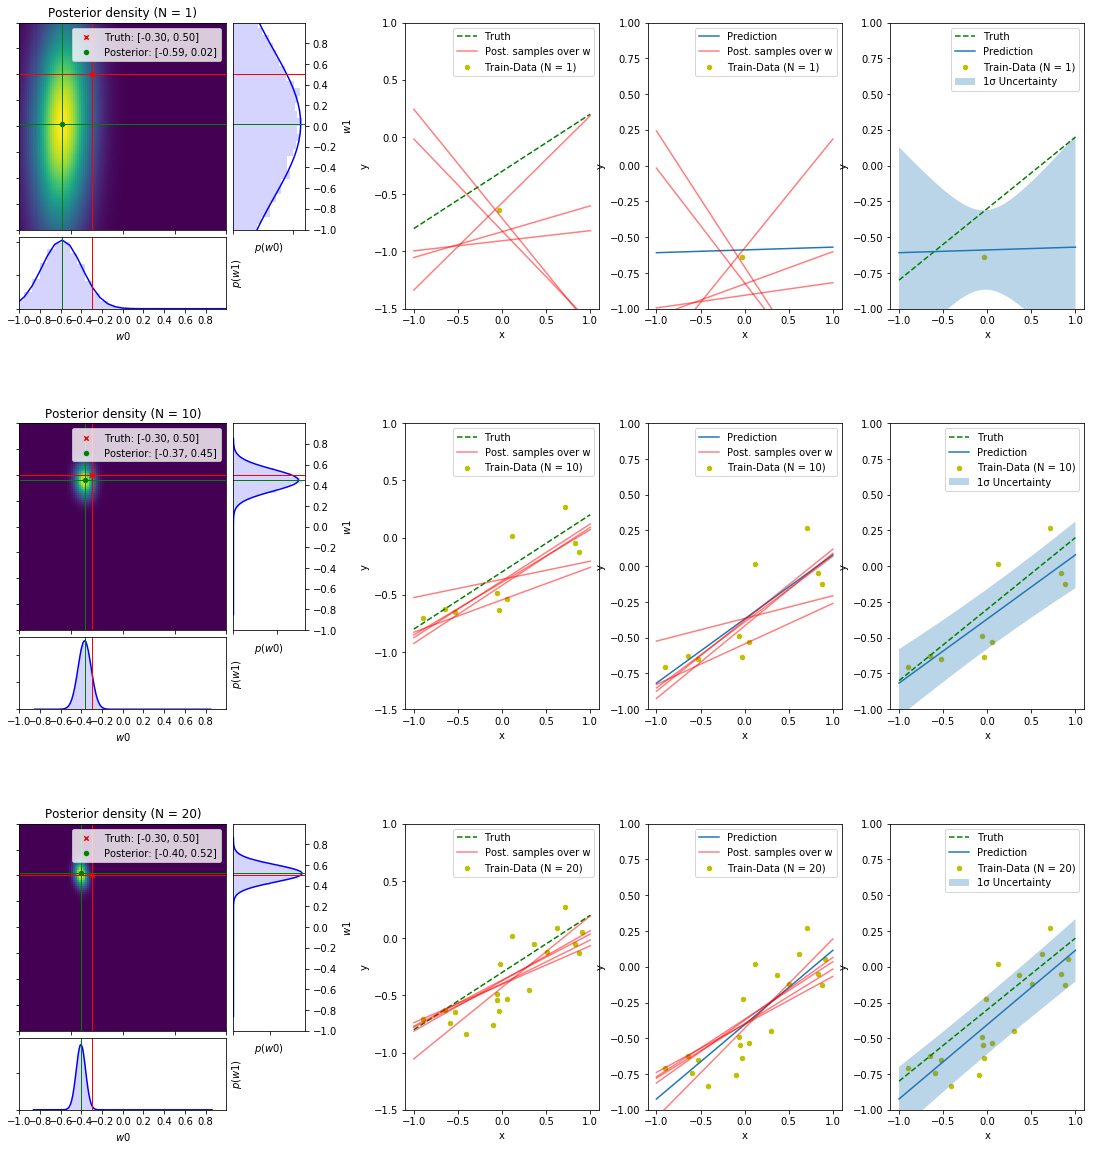

In [19]:
from bayesian_linear_regression_util import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#get_ipython().run_line_magic('matplotlib', 'inline')

# Training dataset sizes (see Page 154,155 in [1])
N_list = [1,10,20]

_from = -1
_to = 1

beta = 1 / (0.2 ** 2) # is equal to 25
alpha = 2.0

# Training observations (datapoints) in [-1, 1)
X = np.random.rand(N_list[-1], 1)*2-1 # *2 -1 to throw datapoints over the entire range [-1,1)

# Training target values for Linear function with noise
t = f(X.ravel(), noise_variance=1/beta)

# Test observations
X_test = np.linspace(_from, _to, 100).reshape(-1, 1)

# Test/Function target values without noise 
y_true = f(X_test, noise_variance=0)

# Could be done this way as well
# Phi_N = design_matrix(X, bf=identity_basis_function)

# Design matrix of test observations for model the relationship between input X_test and target t
Phi_test = design_matrix(X_test, bf=identity_basis_function)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.4)
gs = gridspec.GridSpec(len(N_list), 4, width_ratios=[2, 1, 1, 1], # colums
                                       height_ratios=[1]*len(N_list) ) # rows

xlim = [_from,_to]
ylim = [_from,_to]

for i, N in enumerate(N_list):
    # Training Data points with noise
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = design_matrix(X_N, bf=identity_basis_function)
    
    # Mean and covariance matrix of posterior (weights) based on the training observations
    #m_N, S_N = posterior_distribution(Phi_N[:N], t_N, alpha, beta)
    m_N, S_N = posterior_distribution(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive distribution (targets)
    y, y_var = predictive_distribution(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    

    # First Column
    ax =plt.subplot(gs[i, 0])   
    plot_posterior_joint_distribution(m_N, S_N, w0, w1,xlim,ylim,ax)       
    ax.set_title(f'Posterior density (N = {N})')
    ax.legend()

    #Second Column
    plt.subplot(gs[i, 1])
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    # Third Column
    plt.subplot(gs[i, 2])
    plot_data(X_N, t_N)
    plot_predictive(X_test, y, y_var,plot_uncertainty=False)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(ylim)
    plt.legend()

    # Fourth Column
    plt.subplot(gs[i,3])
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_predictive(X_test, y, y_var)
    plt.ylim(ylim)
    plt.legend()



Each row of the above mentioned output includes an increasing number of training data points defined in `N_list` (yellow dots) with noise.

Since this model has only two parameters, $w_0$ and $w_1$, the output of the posterior distribution mean $m_N$ and covariance $S_N$ with resprect to the true value is plottet as posterior density.

The second column shows 5 random weight samples that are drawn from the posterior distribution values with mean $m_N$ and covariance $S_N$ (red line) as well as the true ("Truth") line, resulting from the true parameters, `w0` and `w1`.

The third colums shows the 5 random weight samples in contrast to the predictive distribution from the posterior.

The last colum shows the mean and the $1\sigma$ standard deviation (uncertainty) of the predictive distribution in contrast to the true model.

It is nice to see that the with increasing size of training data observation the posterior density gets a more sharply peaked gaussian bell and it is getting closer to the true value. This is due to the fact that variance decreases when the number of observations increases. 

This corresponds to a decrease in the sample variance shown in the second column and reflects the reflects the prediction vs posterior samples in the third column.

In the last column we can also clearly see, that in regions with less observation the uncertainty increases. At the points we have observations the uncertainty gets lower. This means that for new datapoints we can be more certain for a correct prediction in this region.

### Gaussian basis functions

As an illustration of the predictive distribution for Bayesian linear regression
models, let's use the synthetic sinusoidal data set $g(x,\mathbf{w}) = {1 \over 2} \sin(2\pi x) + \epsilon$ with the same example values described in Bishops PRML Book. 

Therefore we fit a model comprising a linear combination of Gaussian basis functions to data
sets of various sizes described in `N_list = [1, 2, 4, 25]` and then look at the corresponding posterior distributions.

For creating the design matrix we use 9 Gaussian basis functions with mean distributed over $[0, 1]$ and a constant standard deviation of $\sigma = 0.1$.

Inference for parameters $\mathbf{w}$ is done equally to the previous `Simple linear regression` example ,except that in this example it is not possible (*vielleicht doch, weiß nur noch nicht wie man das für alle $w$ plotten kann, evtl auch als serie von allen oder nur den ersten, den 5 und den letzten*) to plot the posterior density because instead of 2 parameters we now have 10 parameters more precicely the bias term $w_0$ and the 9 Gaussian basis functions $w_1,\ldots,w_9$.



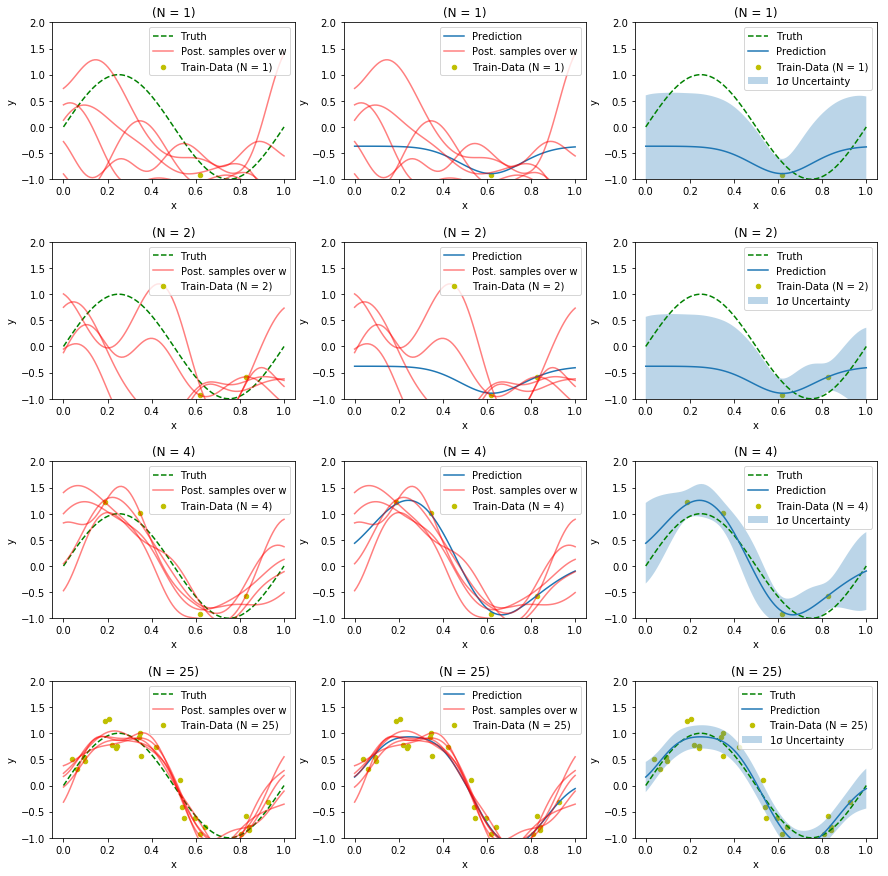

In [6]:
N_list = [1, 2, 4, 25]

# Define Hyperparameters alpha and beta
beta = 1 / (0.2 ** 2) # is equal 25
alpha = 2.0

# Number of basis functions
N_func = 9

# Range of mean values for gaussian basis function
mu = np.linspace(0, 1, N_func)

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1)

# Training target values
t = g(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Test/Function target values without noise 
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = design_matrix(X_test, bf=gaussian_basis_function, bf_args=mu)

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = design_matrix(X_N, bf=gaussian_basis_function, bf_args=mu)
    
    # Mean and covariance matrix of posterior (weights) based on the training observations
    m_N, S_N = posterior_distribution(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive distribution (targets)
    y, y_var = predictive_distribution(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    # First Column
    #plt.subplot(len(N_list), 4, i * 4 + 1,)
    #plot_posterior(m_N, S_N, w0, w1)
    #plt.title(f'Posterior density (N = {N})')
    #plt.legend()

    # Second Column
    plt.subplot(len(N_list), 4, i * 4 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.0, 2.0)
    plt.title(f'(N = {N})')
    plt.legend()

    # Third Column
    plt.subplot(len(N_list), 4, i * 4 + 3)
    plot_data(X_N, t_N)
    plot_predictive(X_test, y, y_var,plot_uncertainty=False)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.0, 2.0)
    plt.title(f'(N = {N})')
    plt.legend()
    
    # Fourth Column
    plt.subplot(len(N_list), 4, i * 4 + 4)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_predictive(X_test, y, y_var)
    plt.ylim(-1.0, 2.0)
    plt.title(f'(N = {N})')
    plt.legend()


The first column shows the 9 random weight samples that are drawn from the posterior distribution values with mean $m_N$ and and covariance $S_N$ (red lines) as well as the true ("Truth) line of the, resulting from the sinusoidal function $g$, of the test observations (dashed line). 

The third colums shows the 9 random weight samples in contrast to the predictive distribution from the posterior.

The last colum shows the mean and the $1\sigma$ standard deviation (uncertainty) of the predictive distribution in contrast to the true model.

We can observe the same behaviour as we have seen in the previous example. If the size of the training observation increases the posterior sample variance and the prediction uncertainty decreases. We also see in the last row that regions with less obeservations have higher prediction uncertainty.

## Evaluation of the evidence function

As mentioned earlier the `evidence function` or `marginal likelihood` can be use for comparing models of different complexity only using training data. To get a feeling about the evidence function, an example of *polynomial basis function* models with $degree=(0 \cdots 9)$ are generated.

For generation of the training data a dataset of $N=10$ oservations is computed using the sinusoidal dataset function `g`.

For this example we still assume that the values of $\alpha$ and $\beta$ are known. These hyperparameters can be inferred by maximizing the log marginal likelihood which will be done aferwards.

In order to evaluate the evidence function the formula from $(22)$ is implemented as `log_marginal_likelihood` function

 $$
 \log p(\mathbf{t} \lvert \alpha, \beta) = {M \over 2} \log \alpha + {N \over 2} \log \beta -
 E(\mathbf{m}_N) - {1 \over 2} \log \lvert \mathbf{S}_N^{-1}\rvert - {N \over 2} \log {2 \pi} \tag{22}
 $$

 where

 $$
 E(\mathbf{m}_N) = {\beta \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{m}_N \rVert^2 +
 {\alpha \over 2} \mathbf{m}_N^T \mathbf{m}_N \tag{23}
 $$


In [7]:
def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = Phi.shape

    m_N, _, S_N_inv = posterior_distribution(Phi, t, alpha, beta, inv_cov=True)
    
    E_D = 0.5 * beta * np.sum((t - Phi.dot(m_N)) ** 2)
    E_W = 0.5 * alpha * np.sum(m_N ** 2)
    
    score = (0.5 * M * np.log(alpha)) + (0.5 * N * np.log(beta)) - (E_D - E_W) - (0.5 * np.log(np.linalg.det(S_N_inv))) - (0.5 * N * np.log(2 * np.pi))

    return score


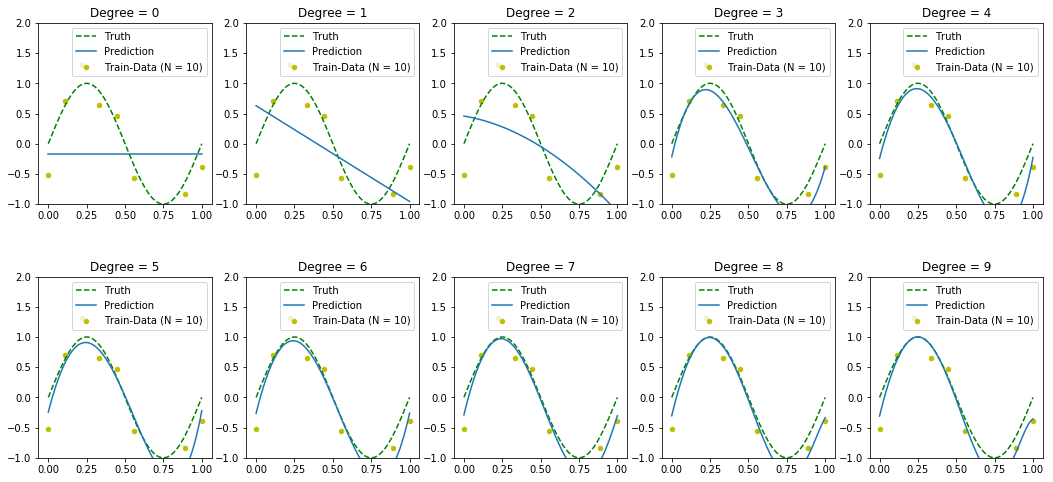

In [8]:
# Number of training observations
N = 10

# Define Hyperparameters alpha and beta
beta = 1 / (0.3 ** 2)
alpha = 0.005

degree = 9
degrees = range(degree + 1)

# Training observations in [-1, 1)
X = np.linspace(0, 1, N).reshape(-1, 1)
#X = np.random.rand(N, 1)

# Training target values
t = g(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Test/Function target values without noise 
y_true = g(X_test, noise_variance=0)

# Create the design matrix
Phi = design_matrix(X, bf=polynomial_basis_function, bf_args=degrees[1:])
Phi_test = design_matrix(X_test, bf=polynomial_basis_function, bf_args=degrees[1:])
#Phi = design_matrix(X, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, N))
#Phi_test = design_matrix(X_test, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, N))

plt.figure(figsize=(18, 8))
plt.subplots_adjust(hspace=0.4)

for d in degrees:
    deg = d + 1
    m_N, S_N = posterior_distribution(Phi[:,:deg], t, alpha, beta)
    y, y_var = predictive_distribution(Phi_test[:,:deg], m_N, S_N, beta)

    plt.subplot(2, 5, deg)
    plot_data(X, t)
    #plot_truth(X_test, y_true, label=None)
    plot_truth(X_test, y_true)
    plot_predictive(X_test, y, np.sqrt(y_var), std_label=None, plot_xy_labels=False, plot_uncertainty=False)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)
    plt.legend()


When looking at the predictive distribution of the polynomial models plotted above we can see that starting from a degree of 3 the model has sufficient complexity to fit the data well.

It is nice to see that when using the Bayesian approach (marginalise (integrate) over all possible choices instead of optimize everything) the problem of overfitting does not occur when using a proper prior. In short: Use a proper prior over model parameter and you can elimate overfitting. This is equivalent to minimizing a sum-of-squares error function plus a quadratic regularization term whose strength is given by ratio $\alpha / \beta$ as can be seen from equation $(16)$.

Now, if we looking at the log marginal likelihood for all polynomial models from the implementation above, we expect that the highest value should be of degree 3 or 4 (depending on the random noise (non-deterministic) the results may vary slightly)
because this is the simplest model which gives a good explanation for the observed data.

degree: {0} mll: {-41.196}
degree: {1} mll: {-30.828}
degree: {2} mll: {-32.831}
degree: {3} mll: {-8.930}
degree: {4} mll: {-12.187}
degree: {5} mll: {-13.095}
degree: {6} mll: {-12.721}
degree: {7} mll: {-12.533}
degree: {8} mll: {-12.764}
degree: {9} mll: {-13.234}


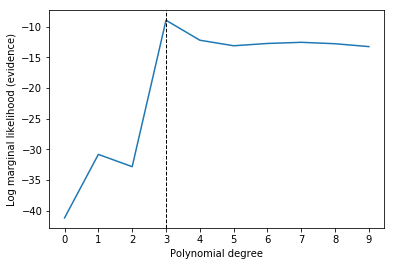

In [9]:
mlls = []

for d in degrees:
    mll = log_marginal_likelihood(Phi[:,:d+1], t, alpha=alpha, beta=beta)
    mlls.append(mll)
    print("degree: {%d} mll: {%2.3f}"%(d,mll))
degree_max = np.argmax(mlls)
    
plt.plot(degrees, mlls)
plt.axvline(x=degree_max, ls='--', c='k', lw=1)
plt.xticks(range(0, 10))
plt.xlabel('Polynomial degree')
plt.ylabel('Log marginal likelihood (evidence)');


As we can see in the plot of the log marginal likelihood output, at a degree of 3 or 4 (depending on the random noise from non-linear sinusoidal function above) the polynomial model is explained sufficiently well. This is consistent with the ovservation we already did and confirms that the `evidence function` or `marginal likelihood` evaluation favors models of intermediate complexity. 

Thus, it is a good approach to do `marginal likelihood` evaluation based on the Testing-Data to get a feeling about the model complexity.


There is some more information that we can obtain from the plot above. Starting from the polynomial `degree = 0`, we see that the polynomial model has very poor fit to the data and consequently gives a relatively low value for the evidence (log marginal likelihood). 

Going to `degree = 1` polynomial model greatly improves the data fit, and hence the evidence is significantly higher. 

However, in going to `degree = 2`, it looks like the polynomial model of `degree = 1` explains the data better than a model of `degree = 2`. This is  due to the fact that the underlying sinusoidal function from which the data is generated is an odd function and so has no even terms in a polynomial expansion see also section 3.4 and 3.5.1. in [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

As already mentioned at a degree of 3 or 4 we get the highest evidence for explaining the data well.


 ## Maximizing the evidence function

For this example we assume that the values of $\alpha$ and $\beta$ are $\bf{Un}$known. In most situations these parameters are unknown and need to be inferred. As mentioned above, these hyperparameters can be inferred by maximizing the log marginal likelihood. 

To estimate the hyperparameters $\alpha$ and $\beta$ we need to iterate over equations $(25)$ and $(26)$ until convergence.

Let us first consider the maximization of $p(\mathbf{t} \lvert \alpha, \beta)$  with respect to $\alpha$ (see equation $(25)$).
This can be done by first defining the following eigentvector equation:
Eigenvalues $\lambda_i$
Eigenvectors $u_i$

$$
    (\beta \boldsymbol\Phi^T\boldsymbol\Phi)u_i = \lambda_i u_i
$$

Note that because the matrix $\boldsymbol\Phi^T\boldsymbol\Phi$ is fixed, we
can compute its eigenvalues once at the start and then simply multiply these by $\beta$ to obtain the $\lambda_i$.

By looking at equation $(25)$ we can see that this is an implicit solution for $\alpha$ not only because $\gamma$ depends on $\alpha$, but also
because the mode $m_N$ of the posterior distribution itself depends on the choice of $\alpha$. We therefore adopt an iterative procedure in which we make an initial choice for $\alpha$ and use this to find $m_N$ with help of the posterior distribution function `posterior_distribution`.


$\bf{Note:}$ It should be emphasized that the value of $\alpha$ has been determined purely by looking at the training data. In contrast to maximum likelihood methods, no independent data set is required in order to optimize the model complexity.

We can similary maximize the log marginal likelihood with respect to $\beta$ (see equation $(26)$). Again, this is an implicit solution for $\beta$ and can be solved by choosing an initial value for $\beta$ also. 

This value can then be use to calculate $m_N$ and $\gamma$ and then re-estimate $\beta$ using equation $(26)$, repeating until convergence.

If both $\alpha$ and $\beta$ are to be determined from the data (as it is in this example), then their values can be re-estimated together after each update of $\gamma$.

This is implemented in the following `fit` function. We start with small values for $\alpha$ and $\beta$ corresponding to a low precision (= high variance) of prior $(12)$ and conditional density $(3)$.

In [10]:
def fit(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_epochs=300, tol=1e-5, verbose=False,plot=False):
    """
    Calculate the optimal values for alpha and beta by maximizing the log marginal likelihood.
    
    Jointly infers the posterior sufficient statistics and optimal values 
    for alpha and beta by maximizing the log marginal likelihood.
    
    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_epochs: Maximum number of epochs(iterations).
        tol: Tolerance for convergence.
        verbose: Print convergence information
        plot: Plot alpha, beta and ratio of alpha/beta

        
    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """
    
    N, M = Phi.shape
    
    # Calculate Eigenvalues of Phi at start because Phi is fixed
    # eigvalsh: eigenvalues of a real symmetric or complex Hermitian (conjugate symmetric) array
    #eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))
    
    # Caluclation of Eigenvalues is like in sklearn BayesianRidge function
    U, S, Vh = np.linalg.svd(Phi, full_matrices=False)
    eigenvalues_0 = S ** 2
       
    beta = beta_0
    alpha = alpha_0
    
    # List for plotting the estimated values
    alphas = []
    betas = []
    
    if plot:
        plt.figure(figsize=(18, 3))       
        plt.subplots_adjust(hspace=0.4)
        converg_alpha = False
        converg_beta  = False
    
    for i in range(max_epochs):
        beta_old = beta
        alpha_old = alpha
        
        # Update eigenvalues by multipling with beta
        eigenvalues = eigenvalues_0 * beta
        
        # posterior distribution of testdata to find m_N
        m_N, S_N, S_N_inv = posterior_distribution(Phi, t, alpha, beta, inv_cov=True)

        # (see eq. 27)
        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        # see(eq. 25)
        alpha = gamma / np.sum(m_N ** 2)
        # see(eq. 26)
        beta_inv = (1 / (N - gamma)) * np.sum((t - Phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv     
                
        alphas.append(alpha)
        betas.append(beta)
        
        # Plot alpha and beta and show when they converge (only for showing that they do not converge at same time)
        if plot:
            # Create list to plott the stuff
            if i > 0 and (np.sum(np.abs(alpha_old - alpha)) < tol) and converg_alpha == False:
            #if i > 0 and np.isclose(alpha_old, alpha, rtol=rtol) and converg_alpha == False:
                converg_alpha = True
                
                # Plot alpha Loss function
                plt.subplot(1, 3, 1)
                plot_precision(i+1,alphas,'alpha')
                plt.legend()

                
            if i > 0 and (np.sum(np.abs(beta_old - beta)) < tol) and converg_beta == False:
            #if i > 0 and np.isclose(beta_old, beta, rtol=rtol) and converg_beta == False:
                converg_beta = True
                
                # Plot beta Loss function
                plt.subplot(1, 3, 2)
                plot_precision(i+1,betas,'beta')
                plt.legend() 
        
        
        # Used the same convergence check as in sklearn BayesianRidge function for alpha and beta
        # Alternatively the np.isclose function could also be used.
        # Note: I did some investiation if it is necessary to split alpha and beta regarding rtol, because 
        # alpha convergence was faster than beta (some epochs), but it is not necessary to split alpha and beta here
        if i > 0 and (np.sum(np.abs(alpha_old - alpha)) < tol) and (np.sum(np.abs(beta_old - beta)) < tol): #and ratio < 2e-3:
            if verbose:
                print(f'Convergence after {i + 1} epochs.')  
            if plot:
                # Plot alpha Loss function
                plt.subplot(1, 3, 3)
                plot_ratio(i+1,np.divide(alphas, betas))
                plt.legend()
            return alpha, beta, m_N, S_N
            
        """    
        # Warning: 1. np.isclose is not symmetric and 2. np.isclose is different to math.isclose
        # https://docs.scipy.org/doc/numpy/reference/generated/numpy.isclose.html
        # https://stackoverflow.com/questions/48156460/isclose-function-in-numpy-is-different-from-math
        """
        #if i > 0 and np.isclose(alpha_old, alpha, rtol=rtol) and np.isclose(beta_old, beta, rtol=rtol):
        #    if verbose:
        #        print(f'Convergence after {i + 1} epochs.')
        #    return alpha, beta, m_N, S_N

    
    # Convergence not possible, maybe need more iterations
    if verbose:
        print(f'Stopped after {max_epochs} epochs.')
    if plot:
        # Plot alpha Loss function
        plt.subplot(1, 3, 3)
        plot_ratio(i+1,np.divide(alphas, betas))
        plt.legend()
    return alpha, beta, m_N, S_N


Next we generate the same sinusoidal training dataset as we already did in `Evaluation of the evidence function`, but without defining the hyperparameters $\alpha$ and $\beta$. This time $\alpha$ and $\beta$ will be evaluated using the `fit` function to estimate the posterior over parameters $\mathbf{w}$ and optimal values for $\alpha$ and $\beta$. 

For generation of the training data a dataset of $N=50$ observations is computed using the sinusoidal dataset function `g` with $\beta_0^{-1} = 0.3^2$ as noise variance. The number of $degree=(0 \cdots 9)$ is set to the same value as before.
The `evidence function` or `marginal likelihood` is also computed again based on the design matrix of the training dataset $\Phi$ to cross check the evidence.

Note: It is possible to estimate $\alpha$ and $\beta$ with `polynomial_basis_function` or `gaussian_basis_function` for training data and plot the results to fit the sinusoidal dataset function `g` by setting the variable `USE_POLY_BF = True or False`.

Calculation with polynomial basis function.
Convergence after 18 epochs.
alpha:0.02241 beta:17.75898 ratio:0.00126


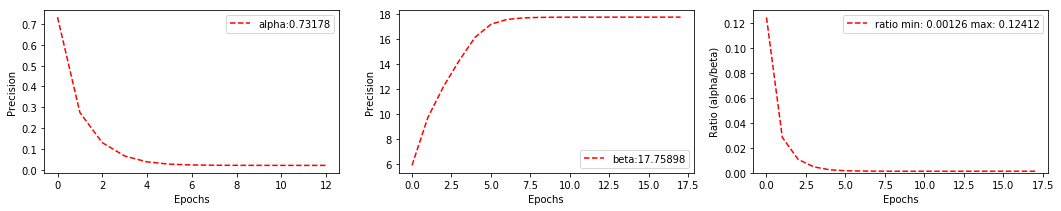

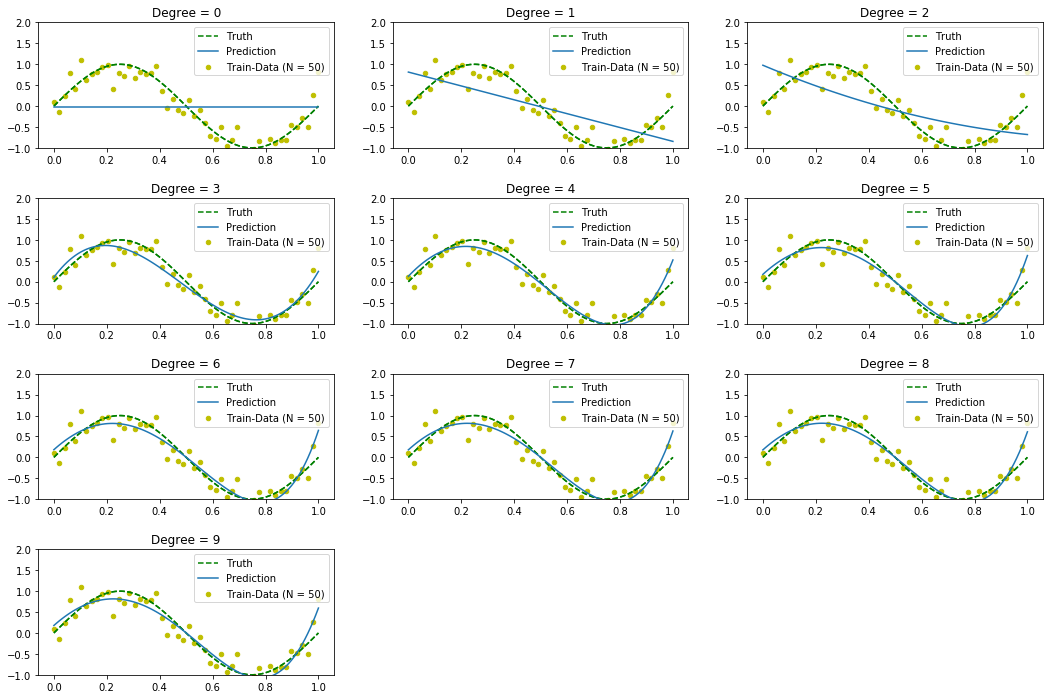

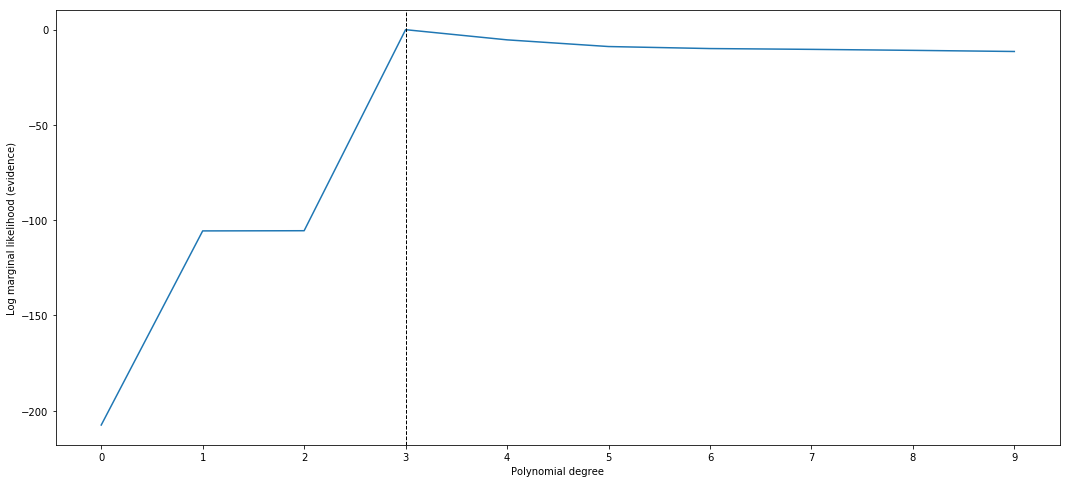

In [20]:
USE_POLY_BF = True

# Number of training observations
N = 50

# Number of degrees for the polynomial bf
degree = 9
degrees = range(degree + 1)

# List for Marginal Likelihood
mlls = []

# Number of basis functions for gaussian bf
N_func = 9

# Range of mean values for gaussian basis function
mu = np.linspace(0, 1, N_func)

# Check the output with different noise e.g. (0.1 ** 2),(0.2 ** 2),(0.3 ** 2),(0.4 ** 2)
beta_0 = 1 / (0.3 ** 2)

# Training observations in [-1, 1)
X = np.linspace(0, 1, N).reshape(-1, 1)
#X = np.random.rand(N, 1)

# Training target values with variance beta_0=0.3^2
t = g(X, noise_variance=1/beta_0)

# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Test/Function target values without noise 
y_true = g(X_test, noise_variance=0)


# Create the design matrix either with polynomial or gaussian basis function 
if USE_POLY_BF == True:
    print(f'Calculation with polynomial basis function.')  
    Phi = design_matrix(X, bf=polynomial_basis_function, bf_args=degrees[1:])
    Phi_test = design_matrix(X_test, bf=polynomial_basis_function, bf_args=degrees[1:])
else:
    print(f'Calculation with gaussian basis function.') 
    Phi = design_matrix(X, bf=gaussian_basis_function, bf_args=mu)
    Phi_test = design_matrix(X_test, bf=gaussian_basis_function, bf_args=mu)


# Calculate the Hyperparameters alpha and beta
#alpha, beta, m_N, S_N = fit(Phi, t, alpha_0=alpha, beta_0=beta, tol=1e-5, verbose=True,plot=True)
alpha, beta, m_N, S_N = fit(Phi, t, tol=1e-5, max_epochs=500, verbose=True,plot=True)

print(f'alpha:{alpha:.5f} beta:{beta:.5f} ratio:{alpha/beta:.5f}')


plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4)

for d in degrees:
    deg = d + 1
    m_N, S_N = posterior_distribution(Phi[:,:deg], t, alpha, beta)
    y, y_var = predictive_distribution(Phi_test[:,:deg], m_N, S_N, beta)

    # calculate Log Marginal Likelihood
    mll = log_marginal_likelihood(Phi[:,:d+1], t, alpha=alpha, beta=beta)
    mlls.append(mll)   

    # Plot the polynomial model
    plt.subplot(np.ceil(degree/3)+1, 3, deg)
    plot_data(X, t)
    plot_truth(X_test, y_true)
    plot_predictive(X_test, y, np.sqrt(y_var), std_label=None, plot_xy_labels=False, plot_uncertainty=False)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)
    plt.legend()

# Plot the evidence function
plt.figure(figsize=(18, 8))
plt.subplots_adjust(hspace=0.4)
degree_max = np.argmax(mlls)
    
plt.plot(degrees, mlls)
plt.axvline(x=degree_max, ls='--', c='k', lw=1)
plt.xticks(range(0, 10))
plt.xlabel('Polynomial degree')
plt.ylabel('Log marginal likelihood (evidence)');

## Validation of results 

To validate the results we implemented with `Maximizing the evidence function` the function [`BayesianRidge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge) from scikit-learn library for Bayesian regression can be used. The `fit` and `predict` methods of `BayesianRidge` are very close to the `fit` and `predictive_distribution` functions we implemented above except that `BayesianRidge` uses [`Gamma`](https://en.wikipedia.org/wiki/Gamma_distribution) distributed priors over parameters $\alpha$ and $\beta$. 

The default hyper-parameter values of the Gamma priors assign high probability density to low values for $\alpha$ and $\beta$. In our implementation, we simply start optimization from low $\alpha$ and $\beta$ values.


When comparing the results from our plain `numpy` implementation with those from `BayesianRidge` we see that they are pretty close to each other. In the following, we want to compare the inferred values for $\alpha$, $\beta$ and $\mathbf{m}_N$ as well as comparing the predictions and their uncertainties. 

Results with `BayesianNumpy` are those from this implementation with pure `numpy`, results with `BayesianRidge` are those obtained with `sklearn.linear_model.BayesianRidge` and results prefixed with `ratio` shows the ratio between both implementations. If the ratio is equal to 1 the values are identical.

Note: In `BayesianRidge` the parameter `lambda` is equal to `alpha` and `alpha` is equal to `beta`. See [Bayesian Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) for more information and howto

In [12]:
def print_validation(title, a, b, a_str='BayesianNumpy', b_str='BayesianRidge'):
    print(title)
    print('-' * len(title))
    print(f'{a_str}: {a}')
    print(f'{b_str}: {b}')
    print(f'Ratio:'+' ' * (len(a_str)-len('Ratio')), np.divide(a,b))
    print("")

In [13]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge(fit_intercept=False, tol=1e-5, verbose=True)
br.fit(Phi, t.ravel());


Convergence after  16  iterations


In [14]:
print_validation('Validate Alpha', alpha, br.lambda_)

Validate Alpha
--------------
BayesianNumpy: 0.012687692916036228
BayesianRidge: 0.012687686391298348
Ratio:         1.0000005142574997



In [15]:
print_validation('Validate Beta', beta, br.alpha_)

Validate Beta
-------------
BayesianNumpy: 12.566007224309043
BayesianRidge: 12.566002036933828
Ratio:         1.0000004128103115



In [16]:
print_validation('Validate Weights', np.mean(m_N.T), np.mean(br.coef_))

Validate Weights
----------------
BayesianNumpy: 0.00830729277419584
BayesianRidge: 0.008307292093714124
Ratio:         1.0000000819137822



In [17]:
# Test values at x = 0.3 and x = 0.7 
X_test = np.array([[0.3], [0.7]])

# Design matrix of test values
Phi_test = design_matrix(X_test, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

In [18]:
y_np_mean, y_np_var = predictive_distribution(Phi_test, m_N, S_N, beta)
y_br_mean, y_br_std = br.predict(Phi_test, return_std=True)

print_validation('Validate Predictive Mean', y_np_mean.ravel(), y_br_mean)
print_validation('Validate Predictive Sigma', np.sqrt(y_np_var), y_br_std)


Validate Predictive Mean
------------------------
BayesianNumpy: [ 0.84354326 -1.01338328]
BayesianRidge: [ 0.84354327 -1.01338328]
Ratio:         [1. 1.]

Validate Predictive Sigma
-------------------------
BayesianNumpy: [0.29141543 0.29275525]
BayesianRidge: [0.2914155  0.29275531]
Ratio:         [0.99999979 0.99999979]



## References

\[1\] Christopher M. Bishop. [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf), Chapter 3.  
\[2\] Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://doc.lagout.org/science/Artificial%20Intelligence/Machine%20learning/Machine%20Learning_%20A%20Probabilistic%20Perspective%20%5BMurphy%202012-08-24%5D.pdf), Chapter 7.  
\[3\] Carl Edward Rasmussen and Christopher K. I. Williams. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/).  

## TODO

* Gamma Verteilung
* Andere Libs außer scikit-learn
* Evtl. alles bisschen kürzen
